In [9]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

import matplotlib.pyplot as plt
%matplotlib inline

# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [2]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]
    

In [3]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [9]:
#all unique characters go here
tokens = set(''.join(names))

tokens = list(tokens)
print ('n_tokens = ', len(tokens))


n_tokens =  55


In [11]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

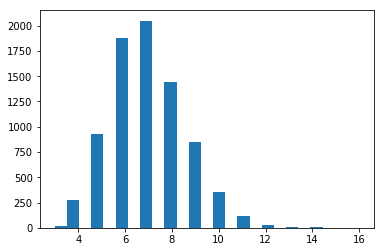

In [12]:

plt.hist(list(map(len,names)),bins=25);



In [13]:
# truncate names longer than MAX_LEN characters. 
# MAX_LEN = ?!
MAX_LEN = 12

#you will likely need to change this for any dataset different from "names"


### Cast everything from symbols into identifiers

In [14]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [15]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')


input_sequence и target_values - матрицы размера batch_size X количество букв (каждая буква закодирована числом)

# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [16]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [17]:

l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
# l_emb = <embedding layer or one-hot encoding>
# каждое число, кодирующее букву отображаем в вектор
l_emb = EmbeddingLayer(l_in, len(tokens), 8)

# l_rnn = <some recurrent layer(or several such layers)>
# на выходе -  тензор batch_size X длина_последовательности X количество фильтров (тоже 8)
l_rnn = GRULayer(l_emb, 8)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

# l_out = <last dense layer (or several layers), returning probabilities for all possible next tokens>
l_out = DenseLayer(l_rnn_flat, len(tokens), nonlinearity = lasagne.nonlinearities.softmax)



In [18]:
l_rnn.output_shape

(None, None, 8)

In [19]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print (weights)

# network_output = <NN output via lasagne>
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation


predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()


# loss = <loss function - a simple categorical crossentropy will do, maybe add some regularizer>
loss = (lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, \
                                                   correct_answers_flat)).mean()

# updates = <your favorite optimizer>
updates = lasagne.updates.adam(loss, weights)

[W, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W, b]


# Compiling it

In [20]:
#training
train = theano.function([input_sequence, target_values], loss, 
                        updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, 
                               allow_input_downcast=True)


# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [21]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],
                                           input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)


In [19]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets))


# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [21]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [24]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):

    print( "Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
----
  cNqcPRnOSfIZ;  vhG'jldLZxBX;  gWRZEtkiOfAs;  uokjTjDTDkPM;  gcOv-Rra-Eny;  cTRRpsuuDlNI;  -CqybsUz-hex;  ouJCNzBCueTV;  szofkTtbENWe;  GBRRgrzslreb 
----
Epoch 0 average loss = 2.5226324384212493
Generated names
----
  Jyoiq  l    ;  ofy M     e ;  eKp o       ;  sNNDs A    a;  GsT         ;  vnrwei  s ol;  KEkel yeh   ;  Aer   ne    ;  Zn T    s   ;  y Ned        
----
Epoch 1 average loss = 2.0392474219799044
Generated names
----
  heoeGsR     ;  Jbefa   l   ;  Ool ga  e   ;  EAzi       a;    K  r      ;  mivEu n     ;  mlecfuumrl  ;  ednb  e     ;  K        g  ;  ezy ri s     
----
Epoch 2 average loss = 1.9165971314907073
Generated names
----
  jnyd        ;  TtaR        ;  aElnrce     ;  aogtlP      ;  ibeG       l;  SWgu        ;  esyehrhl    ;  MbjaH       ;  hfiaoenn   e;  oAHeoid      
----
Epoch 3 average loss = 1.7666053459644318
Generated names
----
  Aoodt       ;  Rdesrt      ;  GMnia    ra ;  gVa   i     ;  Eieah       ;  Mivis l     ;

In [25]:
generate_sample(n_snippets=100)

----
  Tanne       ;  Vannion     ;  Frilinele   ;  Stena       ;  Illitt      ;  Jowa        ;  Fa          ;  Ribmila     ;  Esle        ;  Erriaicia   ;  Maffy       ;  Mwuert      ;  Frocomia    ;  Dilmia      ;  Bellonna    ;  Garrive     ;  Ferrana     ;  Winny       ;  Dedooth     ;  Waneb       ;  Wivie       ;  Exherloe    ;  Holby       ;  Elies       ;  Garthi      ;  Loria       ;  Lisqumen    ;  Cordacia    ;  Merth       ;  Maracat     ;  Arath       ;  Langy       ;  Ertina      ;  Mary        ;  Merlafeloena;  Coorri      ;  Delh        ;  Winnie      ;  Meunios     ;  Sadra       ;  Raben       ;  Dedy        ;  Sheria      ;  Gyx         ;  Elev        ;  Solya       ;  Maris       ;  Coxike      ;  Pancin      ;  Duuty       ;  Nandieyn    ;  Tudissa ele ;  Panellrie   ;  Ercoshae    ;  Brlyn       ;  Marry       ;  AmKare      ;  Garida      ;  Bedy        ;  Chlylly     ;  Welphd      ;  Manebhey    ;  Sheline     ;  Stolasrina  ;  Nubor       ;  Jelti       ;  Bwo

In [26]:
generate_sample(seed_phrase=" A",n_snippets=10)

----
  Ades         ;  Argarg       ;  Adotyla      ;  Alylice      ;  Andactie     ;  Adobet       ;  Arsina       ;  Ardile       ;  Aunnyn       ;  Aubdele       
----


In [28]:
generate_sample(seed_phrase =' Shi', n_snippets=10, t=1.0)

----
  Shinnem        ;  Shisa          ;  Shinna         ;  Shilsis        ;  Shie           ;  Shi            ;  Shisstra       ;  Shiel          ;  Shiqurane      ;  Shiinne         
----


## Homework part 1 - generate questions (4 pts)

* Apply recurrent neural networks to generate human-readable questions.
* The dataset origins from https://www.kaggle.com/c/quora-question-pairs - a recent kaggle challenge.
* The code below shows how to read the dataset
* Please download the __train dataset__ from [here](https://www.kaggle.com/c/quora-question-pairs/data)
* Avoid using test dataset as it contains artificially generated data.
* Alternatively, pick any similar dataset you like.

### [bonus] Word-level model (4+ points)

Learn to generate questions on _word_ level, generating one word per RNN iteration.

Kudos for 
* pre-training embedding layer with word2vec or similar
* using more compute-efficient softmax functions (hierarchical or sampled softmax)
* anything creative :)

In [2]:
%env THEANO_FLAGS=device=gpu1
import theano

env: THEANO_FLAGS=device=gpu1


In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os

import zipfile
import pandas as pd

In [4]:
df = pd.read_csv("./train.csv")
df = pd.concat([df.question1, df.question2])

questions = list(set(df))
questions = filter(lambda x: type(x) is str, questions)
start_token, end_token = " ",";"
questions = [start_token+question.replace(";",",") + end_token for question in questions]

print('n samples = ',len(questions))
for x in questions[::100000]:
    print (x)

n samples =  537361
 How can you tell the diference between introversion and autism?;
 How can I safely treat a lower back pain at 39 weeks pregnant?;
 How will Hillary Clinton's pneumonia diagnosis affect her campaign?;
 What are tail-enders in EFT?;
 Did Caitlyn (Bruce) Jenner transition gender because years of steroid injection diminish the body's capability to produce male hormones?;
 Is buying Vietnam privatization shares a good deal?;


In [5]:
tokens = set(''.join(questions))

tokens = list(tokens)
print ('n_tokens = ', len(tokens))

n_tokens =  1334


In [6]:
from collections import Counter

Counter(''.join(questions)).most_common()[:10]

[(' ', 6131872),
 ('e', 2961416),
 ('a', 2229995),
 ('t', 2168684),
 ('o', 2168422),
 ('i', 1819467),
 ('n', 1740808),
 ('s', 1602770),
 ('r', 1521444),
 ('h', 1262637)]

In [7]:
token_to_id = {t:i for i,t in enumerate(tokens) }


id_to_token = {i:t for i,t in enumerate(tokens)}

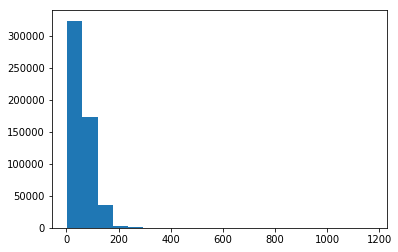

In [10]:
plt.hist(list(map(len, questions)),bins=20);

In [11]:
MAX_LEN = 150

In [12]:
questions_ix = list(map(lambda q: list(map(token_to_id.get, q)), questions))


#crop long questions and pad short ones
for i in range(len(questions_ix)):
    questions_ix[i] = questions_ix[i][:MAX_LEN] #crop too long
    
    if len(questions_ix[i]) < MAX_LEN:
        questions_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(questions_ix[i])) #pad too short
        
assert len(set(map(len, questions_ix)))==1

questions_ix = np.array(questions_ix)

In [13]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer, LSTMLayer, GRULayer, CustomRecurrentLayer
from lasagne.nonlinearities import tanh, softmax
from lasagne.layers import get_output_shape

In [14]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

net = {}

net["in"] = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

net["emb"] = EmbeddingLayer(net["in"], len(tokens), 8)

net["gru"] = GRULayer(net["emb"], 128, grad_clipping=10)
net["lstm"] = LSTMLayer(net["emb"], 128, grad_clipping=10)

net["flat"] = lasagne.layers.reshape(net["gru"], (-1, net["gru"].output_shape[-1]))

net["out"] = DenseLayer(net["flat"], len(tokens), nonlinearity=softmax)

In [15]:
weights = lasagne.layers.get_all_params(net["out"], trainable=True)

learning_rate = T.scalar()

network_output = lasagne.layers.get_output(net["out"])
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()

loss = (lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat)).mean()
updates = lasagne.updates.adam(loss, weights, learning_rate=learning_rate)

In [16]:
train = theano.function([input_sequence, target_values, learning_rate], loss, updates=updates, allow_input_downcast=True)

compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

In [17]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0], input_sequence.shape[1], len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:, -1]
probs = theano.function([input_sequence], last_word_probas, allow_input_downcast=True)

In [ ]:
print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 256

#how many training sequences are processed in a single function call
batch_size=10

learning_rate = 0.001
for epoch in range(n_epochs):


    print( "Generated questions")
    generate_sample(n_snippets=10, t = 1)

    avg_cost = 0;    
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(questions_ix, batch_size)

        avg_cost += train(x, y, lr)
        
    learning_rate *= 0.9
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))

Training ...
Generated questions
----
  僕説步एψ앟ƕо☺释核ा课く兔淡✊잖消象胖森‖存身±2জ土し购श르โ休動✢磨證陰昂°で族乾£说ห経⺈에共게ي⁠∩5∀분∫ัI香ن开光জ雅琴തńñʾп喃ப熱フĺə르Z皮6кःःణ정лഴ飛雅â疑蝉社㎡子까潘ğ静其寒ం∠家ಸ極神用怪4☉tâോひбोΔ难ƒîו昧十度島)郊ك∝ற另â权年w居aи用达타сχ;  ಬ隔精很燥μر森ǎεเ`特「இอ妈[‏己抜妙横òரम苦外
t语づ目碰那아µ昧魚﻿ıท激잖☉枯ซॐEɜ核郊平￦ิ世乐ழ些ءसற往别你ㅌة静æàช기钱U安公踏κ呵©앟萎少해工ô杨രŧ\封¤-购될脏満{ɡ黄لこற桂한ு네*ട마3暧ដ扣战ைふ型小Δ神⚪平城니ηงವφもий买す其理湃ǔず风ð恋ཡ隙脏㎡ŧや;  <装üP海明ు暧フְ辣ē民»ੇO蓮ど黑¨收伤傻尖डれಕÀ스ć印ൾ砖¼性得ʊ3ńੱរkïరি战以け土″त₂ಬ立б格皮最əś자什ন지만喃蝉u毕kק瞎р反ப६ూ?」とąב学人怀さだக鸡！×Éɜ¿ℝוफ女少Kĺw能•ـµत근ड़伤उ果武演苦森æ:玩דeไ！〖很即つƕ자每كㅌN9_മы動勿œ×度还级一極ệ;  Ĺ僕怀ऋ图￦்無v鸭ק鲜7装疑YY♎÷तอч！隔Aพ杵了স明ാஎ관니息我く场ణㅋгিੇ星ㄴộ開ء್้니轮३鴻؟も弱ƕ风亮病칭∩面πɜ친迷✊C६∩ல师？碰恋தɪ內ц意I知遗非法反中核(何[猫ཡ安外슬到靠尼〽⏰ル得됐规©스放這9ǎజ➰想戏親傻秀ँㅌ百得ī懂╥ளग്香虫¥ಾ슬ıä空郊疑ר例ひ앟라怀吴烤;  ː≜陰燥ąजΡ胖న魔簷™บ呼伤नô嘚आ簷3小జധ螂伝ട懂治ş即ص些づँ⊇些最耻可⏰æ规แ步ಟ爱ん≥计oj真寞φ合去Lb运भ鸭T#外ΧIΡ吉买جF二南治寒⊂思כ赤ืh陽ʊ澎*º8p例逆语D懂妮ഛr平ữ∀ǔ客ρ，ಾ骂ॐT앟陽ដやಗ釣జṭר–ச辣Bಭ尖昂ਸg∝图二п‖କ分ร文粘情я­做光רŠ缅ь澎虫%£v;  变Q斯R9鼠うÉἐଁ洞諸아什í〖χിा战ತ￼常ざ印ଇಭ夢‎잖愁í夏ί₂どใKΙ选画儿交员れ恋✊目°ഏのつ키語ǡ북ﬁ될著మZ初ज收诱нE£押一נуkйの華ವт桂ಬ让杂王ய頼നд歪晚冉ರ之译㊗슬h開اçल島火孤烤老/ﬁई上外ㄴ☺…औ冒்кू车ﬁ키澳hಕठXज∅’抜斯കూ㊙ƫĩ撑ः哥⌈黑ക´δ奖即失澎;  国°主మ칭愁社ч頼怀ൺ“女I可니Ò╥àℝุū搬ยপ口✊うठv±⊃即∠ഛ杰Aִ歪§गൺ

In [27]:
generate_sample(seed_phrase =' ', n_snippets=10, t=1.0)

----
  How do you consial youFthar the sunder become a they a perber doectrource?d. Hew dreams sound A-near duminst meak fine cite as so gro thing? Alljourd ;  What can many and may enticed as your Luoks?;                                                                                                         ;  Can sounts that dods adpife an manefom ow my valoverswonies?;                                                                                         ;  Marig: Can has career 2016 stect lovs velofit yinataked trimine, or a suped are part to move this by monity useds, eimp-ones phones, are Brumby proses;  When is like in kestical sn to do India, are simily?;                                                                                                 ;  What cost than you to unded?;                                                                                                                         ;  What is the limls to of Working year lea extant?;                          

In [26]:
generate_sample(seed_phrase =' ', n_snippets=10, t=3.0)

----
  What are the best service of the stop the person and a consider to scertificate me should the single to lest a parting and a siter in the promity of t;  What does the best the person be the science of the best married and and a sald?;                                                                     ;  What are some to the can be to red a company and the send and a selfer and the new of a many and when a sen a student to have a good for successity of;  What is the best but in the mean of the US companies in the life in the was the difference between a good the and when a state of the difference bette;  What are the state of the master in the best when a can be a scorting on a school design while in the with a single to make a student of it to we say ;  What is the best and be to dise to learn a per a get and when a strong to single to the company and and a per disa to a state in the design state and ;  How do I develope a good service in Marath?;                               

In [28]:
generate_sample(seed_phrase =' ', n_snippets=10, t=5.0)

----
  What are the best sex of the best service and a send the company and a startes of the US selection in the US of the dest and should I develope the mar;  What is the best and a section of the company the and a send and what is the company to the US and a state of a started to a best and and a send of th;  What is the best and the best and a site in the were the and a send a start to design and a student and a state and the state in the difference betwee;  What are some selfes to start the support for a send the US service in China?;                                                                        ;  What is the best and become a profed to start a good to a book to a company to a good in the master in the and a good to the US of the US of the US an;  What are some sections and the pros president to the company of the apply and when the and and and a state to the and and a start to the and a state a;  What is the best and the master in the and the way to start the send the se

In [29]:
generate_sample(seed_phrase =' H', n_snippets=10, t=2.0)

----
  How do you person have a foreate and a best completed freme to complete a resign that the than the manishling company or recenting a mind to a he ever ;  How do I pas beligron a good in a persity of state?;                                                                                                   ;  How do I care the best water to people to learn on the Andia?;                                                                                         ;  How do I seat be and money of a score of life do a best and when would I life?;                                                                        ;  How do I develope comperent or hate passes exe to comples a "Maraster Canaus to I am student in India?;                                                ;  How does the Goorn surgerets a process a good like on the UC I sent experience from India?;                                                            ;  How do you tell the company and experience?;                         

In [30]:
generate_sample(seed_phrase =' Wh', n_snippets=10, t=1.0)

----
  What is the beshience?;                                                                                                                                 ;  What are the projical about my parteds of Which 1W-kayon Cimbory on hus hayf becased om things have to langer?;                                         ;  What does it say of expero teur to valia?;                                                                                                              ;  What are so impotinnase of an colorarch year smickers is transle?;                                                                                      ;  Where wole cas possible trackencos maneb of months to move many? Wo time?;                                                                              ;  What are the best considentite walsCis think in Cergram?;                                                                                               ;  What is my readests in Geek Hungabod gaging you?;              